In [1]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

<ipython-input-1-d867fd071f7d>:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pywt
from PIL import Image  
import PIL  
from skimage.io import imsave, imread

In [4]:
from dask import bag, diagnostics 
#import hvplot.pandas
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import shutil

import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from keras.layers import Input
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop

In [6]:
import math
from keras.layers import MaxPool2D, concatenate, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from keras.layers import Concatenate
import keras.backend as K
import keras
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler

# **Googlenet**

In [7]:
#Defining the model
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [8]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def googleNet():
  #GoogleNet Architecture
  input_layer = Input(shape=(224, 224, 3))

  x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
  x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
  x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=64,
                      filters_3x3_reduce=96,
                      filters_3x3=128,
                      filters_5x5_reduce=16,
                      filters_5x5=32,
                      filters_pool_proj=32,
                      name='inception_3a')

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,
                      filters_3x3=192,
                      filters_5x5_reduce=32,
                      filters_5x5=96,
                      filters_pool_proj=64,
                      name='inception_3b')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=192,
                      filters_3x3_reduce=96,
                      filters_3x3=208,
                      filters_5x5_reduce=16,
                      filters_5x5=48,
                      filters_pool_proj=64,
                      name='inception_4a')


  x1 = AveragePooling2D((5, 5), strides=3)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(5, activation='softmax', name='auxilliary_output_1')(x1)

  x = inception_module(x,
                      filters_1x1=160,
                      filters_3x3_reduce=112,
                      filters_3x3=224,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4b')

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,
                      filters_3x3=256,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4c')

  x = inception_module(x,
                      filters_1x1=112,
                      filters_3x3_reduce=144,
                      filters_3x3=288,
                      filters_5x5_reduce=32,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4d')


  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.7)(x2)
  x2 = Dense(5, activation='softmax', name='auxilliary_output_2')(x2)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_4e')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5a')

  x = inception_module(x,
                      filters_1x1=384,
                      filters_3x3_reduce=192,
                      filters_3x3=384,
                      filters_5x5_reduce=48,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5b')

  x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

  x = Dropout(0.4)(x)

  x = Dense(5, activation='softmax', name='output')(x)

  #Concatenating the models
  return Model(input_layer, [x, x1, x2], name='GoogleNet')


In [9]:
model_gn = googleNet()
model_gn.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                        

In [10]:
epochs = 25
initial_lrate = 0.001

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model_gn.compile(loss=['categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])
#model_gn.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
IMG_SIZE = 224

In [17]:
data_path = '/content/drive/MyDrive/Sem 2/CV/5G_Data/'

In [18]:
classes = list(os.listdir('/content/drive/MyDrive/Sem 2/CV/5G_Data/'))
print(classes)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']


In [19]:
BATCH_SIZE = 32

In [20]:

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names= classes,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names= classes,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False
)

Found 2002 files belonging to 5 classes.
Using 1602 files for training.
Found 2002 files belonging to 5 classes.
Using 400 files for validation.


In [21]:
import torch
device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")

In [22]:
hist_gn = model_gn.fit(train_dataset,
                    validation_data= val_dataset,
                    epochs=epochs, 
                    )

Epoch 1/25


51/51 [==============================] - 622s 10s/step - loss: 1.7896 - output_loss: 1.7896 - output_accuracy: 0.2010 - auxilliary_output_1_accuracy: 0.2066 - auxilliary_output_2_accuracy: 0.2072 - val_loss: 1.6629 - val_output_loss: 1.6629 - val_output_accuracy: 0.1650 - val_auxilliary_output_1_accuracy: 0.2125 - val_auxilliary_output_2_accuracy: 0.2250
Epoch 2/25
51/51 [==============================] - 14s 256ms/step - loss: 1.6844 - output_loss: 1.6844 - output_accuracy: 0.1816 - auxilliary_output_1_accuracy: 0.2022 - auxilliary_output_2_accuracy: 0.1941 - val_loss: 1.6682 - val_output_loss: 1.6682 - val_output_accuracy: 0.2125 - val_auxilliary_output_1_accuracy: 0.2100 - val_auxilliary_output_2_accuracy: 0.2250
Epoch 3/25
51/51 [==============================] - 14s 254ms/step - loss: 1.6640 - output_loss: 1.6640 - output_accuracy: 0.1948 - auxilliary_output_1_accuracy: 0.1860 - auxilliary_output_2_accuracy: 0.2135 - val_loss: 1.6307 - val_output_loss: 1.6307 - val_output_accuracy

In [23]:
hist_gn.history.keys()

dict_keys(['loss', 'output_loss', 'output_accuracy', 'auxilliary_output_1_accuracy', 'auxilliary_output_2_accuracy', 'val_loss', 'val_output_loss', 'val_output_accuracy', 'val_auxilliary_output_1_accuracy', 'val_auxilliary_output_2_accuracy'])

In [24]:
model_gn.evaluate(val_dataset)



13/13 [==============================] - 2s 81ms/step - loss: 0.9645 - output_loss: 0.9645 - output_accuracy: 0.3775 - auxilliary_output_1_accuracy: 0.2125 - auxilliary_output_2_accuracy: 0.2125


[0.9644595980644226,
 0.9644595980644226,
 0.3774999976158142,
 0.21250000596046448,
 0.21250000596046448]

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, zero_one_loss, classification_report

In [30]:
y_test = np.array([])
y_pred = np.array([])
for images, labels in val_dataset:
 y_test = np.append(y_test, np.array(labels).argmax(axis=1))
 y_pred= np.append(y_test, np.array(model_gn.predict(images)).argmax(axis= -1))

1/1 [==============================] - 1s 1s/step


In [34]:
cm = confusion_matrix(y_test,y_pred)
print(cm, '\n')
zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')
cr = classification_report(y_test, y_pred)
print(cr)

[[73  0  0  0  0]
 [ 0 90  0  0  0]
 [ 0  0 66  0  0]
 [ 0  0  0 86  0]
 [ 0  0  0  0 85]] 

0 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        73
         1.0       1.00      1.00      1.00        90
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        86
         4.0       1.00      1.00      1.00        85

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<Figure size 500x500 with 0 Axes>

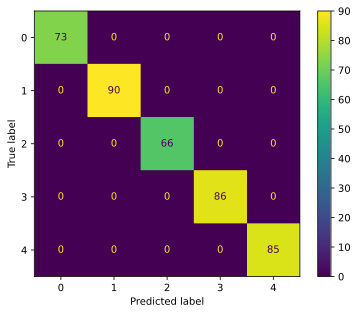

In [35]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

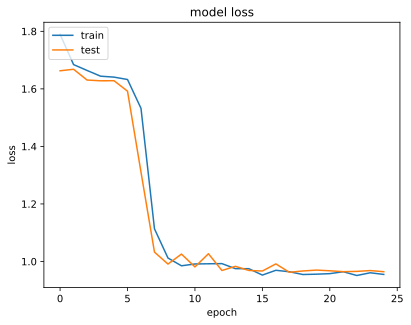

In [26]:
# summarize history for loss
plt.plot(hist_gn.history['loss'])
plt.plot(hist_gn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

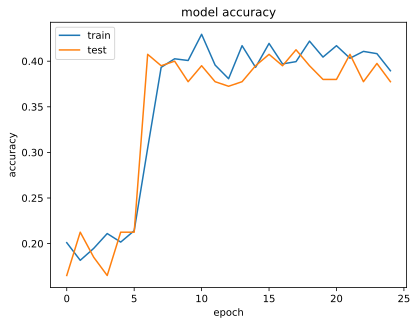

In [27]:
# summarize history for accuracy
plt.plot(hist_gn.history['output_accuracy'])
plt.plot(hist_gn.history['val_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/Qs_4_1_Assignment_Beta_ACV.ipynb ./

In [ ]:
!jupyter nbconvert --to PDF "Qs_4_1_Assignment_Beta_ACV.ipynb"

In [ ]:
%rm -rf /content/TRAIN/YES